# Bike Calculator

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import matplotlib as mpl
import math
import numpy as np
import glob
import os
import pandas as pd
import json
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

G = 9.81

In [2]:
CASSETTES = {
    '11-25T': [11,12,13,14,15,16,17,19,21,23,25],
    '11-28T': [11,12,13,14,15,17,19,21,23,25,28],
    '14-28T': [14,15,16,17,18,19,20,21,23,25,28],
    '11-32T': [11,12,13,14,16,18,20,22,25,28,32],
    '11-34T': [11,13,15,17,19,21,23,25,27,30,34],
    '11-36T': [11,12,13,15,17,19,22,25,28,32,36],  # SRAM RIVAL22 PG-1130 11SP 11-36T
    '11-40T': [11,13,15,17,19,21,24,27,31,35,40],  # SHIMANO DEORE XT CS-M8000
}

# Default values. Change these.
if True:
    BODY_WEIGHT = 80
    BIKE_WEIGHT = 10
    FTP = 200
    AVG_POWER = 157
    MAX_POWER = 355
    MIN_SPEED = 3.5
    MIN_CADENCE = 34
    MAX_CADENCE = 110
    TIRE_SIZE = (700,30)
    CASSETTE = '11-34T'
    CHAINRINGS = [46, 30]
else:
    BODY_WEIGHT = 82
    BIKE_WEIGHT = 10
    FTP = 200
    AVG_POWER = 144
    MAX_POWER = 355
    MIN_SPEED = 3.5
    MIN_CADENCE = 34
    MAX_CADENCE = 110
    TIRE_SIZE = (700,28)
    CASSETTE = '11-34T'
    CHAINRINGS = [50, 34]
    
CHAINRING = CHAINRINGS[1]
MAX_TORQUE = 9

# table: https://www.cateye.com/data/resources/Tire_size_chart_ENG_151106.pdf
wheel_circumferes_mm = {
    (700,25): 2105,
    (700,28): 2136,
    (700,30): 2146,
    (700,38): 2180,
}

# From bikecalculator.com
# view-source:http://bikecalculator.com/bikecalculator.js
CRR = {
    'clincher': 0.005, 
    'tubular': 0.004, 
    'mtb': 0.012
}

FRONTAL_AREA = {
    'hoods': 0.388, 
    'bartops': 0.445, 
    'barends': 0.420, 
    'drops': 0.300, 
    'aerobar': 0.233, 
    'xxx': 0.200
}


## Bike Physics

In [3]:
def calculate_air_density(altitude, temperature=25):
    return (1.293 - 0.00426 * temperature) * math.exp(-altitude / 7000.0)

# From https://www.michael-konczer.com/en/training/calculators/bike-speed-and-power-calculator
# (original code: https://www.michael-konczer.com/javascript/speed-and-power.js)
def calculate_air_density2(altitude, temperature=25):
    # Conczer
    # constants used
    Rs = 287.058
    normPressure = 101325

    temperature = temperature + 273.15     # convert from °C to K
    airPressure = normPressure * math.pow((1 - (6.5 * altitude / 288000)), 5.256)
    airDensity = airPressure / (Rs * temperature)

    return airDensity


def calculate_power_2(distance, ascent, speed, body_weight, bike_weight,
                    drag=0.3, rolling_drag=0.01, air_density=1.17):
    # Conczer
    results = dict()
    total_weight = body_weight + bike_weight

    # calculate
    results['time'] = pd.Timedelta(seconds=distance * 3600 / 1000 / speed)

    gradient = ascent / (math.sqrt(distance**2 - ascent**2))
    speed_ms = speed / 3.6
    ascend_speed = gradient * speed_ms / (math.sqrt(1 + gradient**2))

    results['gradient'] = gradient
    results['power_air'] = drag * 0.5 * air_density * speed_ms**3
    results['power_rolling'] = total_weight * G * rolling_drag * speed_ms
    results['power_ascent'] = total_weight * G * ascend_speed

    results['power_total'] = results['power_air'] + results['power_rolling'] + \
                             results['power_ascent']
    results['wkg'] = results['power_total'] / body_weight

    return results


def calculate_speed_2(distance, ascent, power_total, body_weight, bike_weight, 
                      position='hoods', tyre='clincher', altitude=100, temperature=25):
    # Conczer
    b = 0
    c = 0
    p = 0
    q = 0
    D = 0
    rolling_drag = CRR[tyre]
    air_density = calculate_air_density(altitude, temperature)
    drag = 0.5 * FRONTAL_AREA[position] * air_density
    total_weight = body_weight + bike_weight
    k = ascent / (math.sqrt(distance**2 - ascent**2))
    speed = 0

    # solve formula of 3rd order
    b = 2 * total_weight * G / (drag * air_density) * (rolling_drag + k / math.sqrt(1 + k**2))
    p = b
    c = -2 * power_total / (drag * air_density)
    q = c
    D = q**2 / 4 + p**3 / 27

    # check which case to us
    if (D > 0):
        speed = math.pow((-q / 2 + math.sqrt(D)), 1/3) - math.pow((q / 2 + math.sqrt(D)), 1/3)

    speed = speed * 3.6
    return speed


def newton(aero, hw, tr, tran, p):
    vel = 20       # Initial guess
    TOL = 0.05     # tolerance
    for i in range(1, 11):
        tv = vel + hw
        aeroEff = aero if (tv > 0.0) else  -aero # wind in face, must reverse effect
        f = vel * (aeroEff * tv**2 + tr) - tran * p # the function
        fp = aeroEff * (3.0 * vel + hw) * tv + tr     # the derivative
        vNew = vel - f / fp
        if (abs(vNew - vel) < TOL):
            return vNew  # success
        vel = vNew

    assert False
    return 0.0  # failed to converge


# From bikecalculator.com
# view-source:http://bikecalculator.com/bikecalculator.js
def calculate_speed(distance, ascent, power, body_weight, bike_weight, 
                    position='hoods', tire='clincher', altitude=100, temperature=25,
                    headwind=0):
    # distance, ascent: meter
    # power: watt
    # weights: kg
    # headwind: kph
    total_weight = body_weight + bike_weight
    crr = CRR[tire];
    frontalArea = FRONTAL_AREA[position]
    grade = ascent / distance
    headwind /= 3.6  # converted to m/s
    transv = 0.95 # no one knows what this is, so why bother presenting a choice?
    
    # Common calculations
    density = calculate_air_density(altitude, temperature)
    twt = 9.8 * total_weight  # total weight in newtons
    A2 = 0.5 * frontalArea * density  # full air resistance parameter
    tres = twt * (grade + crr) # gravity and rolling resistance
    
    v = newton(A2, headwind, tres, transv, power) * 3.6      # convert to km/h
    return v


# From bikecalculator.com
def calculate_power(distance, ascent, speed, body_weight, bike_weight, 
                    position='hoods', tire='clincher', altitude=100, temperature=25,
                    headwind=0):
    total_weight = body_weight + bike_weight
    crr = CRR[tire];
    frontalArea = FRONTAL_AREA[position]
    grade = ascent / distance
    headwind /= 3.6  # converted to m/s
    transv = 0.95 # no one knows what this is, so why bother presenting a choice?
    
    # Common calculations
    density = calculate_air_density(altitude, temperature)
    twt = 9.8 * total_weight  # total weight in newtons
    A2 = 0.5 * frontalArea * density  # full air resistance parameter
    tres = twt * (grade + crr) # gravity and rolling resistance
    
    v = speed / 3.6 # converted to m/s
    tv = v + headwind
    A2Eff = A2 if (tv > 0.0) else -A2 # wind in face, must reverse effect
    power = (v * tres + v * tv**2 * A2Eff) / transv

    return power


## Speed/Cadence

In [4]:
# Reference: http://www.tariksaleh.com/bike/geartospeed.pdf
def cadence_at_speed(speed, chainring, cassette, tire_size):
    wheel_circ = wheel_circumferes_mm[tire_size] / 1000
    ratio = chainring / cassette
    minutes = 60
    development = wheel_circ * ratio
    cadence = speed * 1000 / development / minutes
    return round(cadence)


def speed_at_cadence(cadence, chainring, cassette, tire_size):
    wheel_circ = wheel_circumferes_mm[tire_size] / 1000
    ratio = chainring / cassette
    development = wheel_circ * ratio
    speed = development * cadence * 60 / 1000
    return speed

### Cadence at speed demo

In [19]:
IDEAL_CADENCE = 90

def cadence_at_speed_demo(chainrings, cassettes, tire_size, min_speed=25, max_speed=45, speed_inc=1):
    
    def color_fader(c1='lightgreen', c2='white', mix=0):
        c1 = np.array(mpl.colors.to_rgb(c1))
        c2 = np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    def get_bg_style(arr):
        def get_color(cad):
            cad = int(cad) if cad else 0
            diff = min(abs(IDEAL_CADENCE-cad)/10, 1)
            return color_fader(mix=diff)
        return [f'background-color: {get_color(cad)}' for cad in arr]

    rows = []
    for ring in chainrings:
        for cog in cassettes:
            row = dict(cogs=f'{ring}x{cog}')
            for speed in np.arange(min_speed, max_speed+speed_inc, speed_inc):
                cad = cadence_at_speed(speed, ring, cog, tire_size)
                cad = str(cad) if cad >= 40 and cad <= 120 else ''
                row[str(speed)] = cad
            rows.append(row)
    df = pd.DataFrame(rows).set_index('cogs')
    columns = [('speed (km/h)', c) for c in df.columns]
    df.columns = pd.MultiIndex.from_tuples(columns)
    return df.style.apply(get_bg_style)


chainrings = CHAINRINGS
if False:
    sprocket = '11-32T'
else:
    sprocket = '11-34T'
cassettes = CASSETTES[sprocket]
display(Markdown(f'### Cadence at speed: {chainrings} vs {sprocket}'))
cadence_at_speed_demo(chainrings, cassettes, TIRE_SIZE, 
                      min_speed=5, max_speed=50, speed_inc=1)



### Cadence at speed: [46, 30] vs 11-34T

## Power at speed: power to maintain speed at various gradients


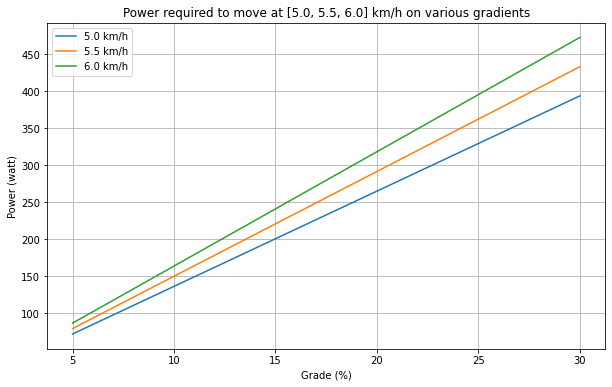

In [6]:
def power_at_speed(speeds):
    grades = pd.Series(np.arange(5,31,5))
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    for speed in speeds:
        powers = grades.apply(lambda grade: calculate_power(1000, 1000*grade/100, speed, 
                                                            BODY_WEIGHT, BIKE_WEIGHT))
        df = pd.DataFrame({'grade': grades, 'power': powers}).set_index('grade')
        ax.plot(df['power'], label=f'{speed} km/h')
        
    ax.set_title(f'Power required to move at {speeds} km/h on various gradients')
    ax.set_xlabel('Grade (%)')
    ax.set_ylabel('Power (watt)')
    ax.grid()
    ax.legend()
    plt.show()

# Test
power_at_speed( [5.0, 5.5, 6.0] )

## Cadence at power: speed/cadence at specified power/chainring/cog

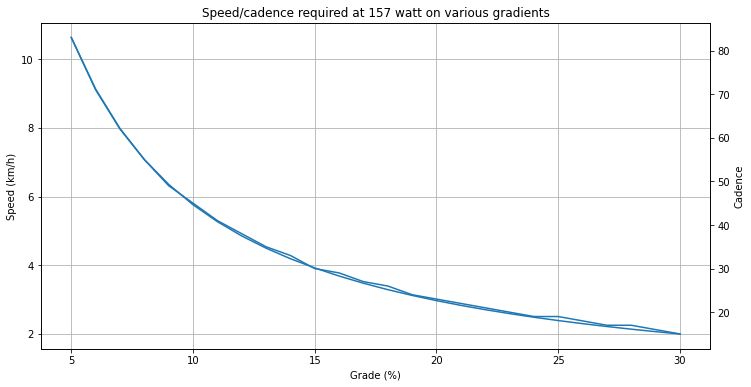

In [7]:
def cadence_at_power(power, chainring, cog, tire_size=(700,30)):
    grades = pd.Series(np.arange(5,31))
    speeds = grades.apply(lambda grade: calculate_speed(1000, 1000*grade/100, power, 
                                                        BODY_WEIGHT, BIKE_WEIGHT))
    cadences = speeds.apply(lambda s: cadence_at_speed(s, chainring, cog, tire_size))
    
    df = pd.DataFrame({'grade': grades, 'speed': speeds, 'cadence': cadences}).set_index('grade')
    
    fig = plt.figure(figsize=(12,6))
    
    ax = df['speed'].plot()
    ax.set_title(f'Speed/cadence required at {power} watt on various gradients')
    ax.set_xlabel('Grade (%)')
    ax.set_ylabel('Speed (km/h)')
    ax.grid()
    
    ax2 = ax.twinx()
    df['cadence'].plot(ax=ax2)
    ax2.set_ylabel('Cadence')
    
    plt.show()

# Test
cadence_at_power(157, 34, 34, (700,30))

## Utility: Max Torque Finder

Find maximum torque of an activity, where `torque = power / cadence`.

In [8]:
from ztraining import ZwiftTraining

In [9]:
def find_max_torque(file, duration):
    df, meta = ZwiftTraining.parse_file(file, sport='cycling')
    df = df.set_index('dtime')
    df = df[['power', 'cadence', 'speed', 'hr']]
    df = df[ df['power'] > 50 ]
    df = df[ df['cadence'] > 10 ]
    df['power ma'] = df['power'].rolling(duration).mean()
    df['cadence ma'] = df['cadence'].rolling(duration).mean()
    df['torque ma'] = df['power ma'] / df['cadence ma']
    df['speed ma'] = df['speed'].rolling(duration).mean()
    
    print(f'Max {duration}s power:')
    ploc = df['power ma'].idxmax()
    #print(df.loc[ploc])
    row = df.loc[ploc]
    print(row[['power ma', 'cadence ma', 'speed ma', 'torque ma']])
    print('')
    
    print(f'Max {duration}s torque:')
    tloc = df['torque ma'].idxmax()
    row = df.loc[tloc]
    #print(df.loc[tloc])
    print(row[['power ma', 'cadence ma', 'speed ma', 'torque ma']])

    
dir = '/home/bennylp/Desktop/tmp/import activities/'
files = [
    'Yogya_Ultra_Challenge_YUCC_200km_dnf_.gpx',
    'GG_Kesiman.gpx',
    '04 Mbolang_ke_Malang_Batu_Cangar.gpx',
    '03 Pacet.gpx',
    'Nongkojajar.fit',
]

if False:
    for f in files:
        f = os.path.join(dir, f)
        display(Markdown('### ' + os.path.basename(f)))
        #print('-' * 40)
        find_max_torque(f, 5)
        print('')

## Gradients Summary of GPX/TCX/FIT file

Calculate the total distance and eg of each gradient in a GPX/TCX/FIT file. Plot it too for visualization.

In [10]:
def summarize_gradients(file, min_grad=1, max_grad=50, min_mov=2, ma_period=3):
    df, meta = ZwiftTraining.parse_file(file, sport='cycling')
    df['eg'] = df['elevation'].diff()
    df['grade'] = (df['eg'] / df['movement']).fillna(0.0)
    df['grade ma'] = df['grade'].rolling(ma_period).mean().fillna(0.0)
    df['grade ma'] = (df['grade ma'] * 100).astype(int)
    
    df = df[['distance', 'elevation', 'movement', 'eg', 'grade ma']]
    
    summary = df.groupby('grade ma').agg('sum')
    summary = summary[['movement', 'eg']].round(0).astype(int)
    summary = summary.loc[min_grad:max_grad,:]
    summary = summary[ summary['movement'] >= min_mov ]
    return summary


def plot_gradients(files, min_grad=1, max_grad=35):
    grad_summaries = {}
    for f in files:
        title = os.path.basename(f)
        df = summarize_gradients(f)
        grad_summaries[title] = df
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    for i, (title, df) in enumerate(grad_summaries.items()):
        df = df.loc[min_grad:max_grad,:]
        df['movement'].plot(ax=ax, color=f'C{i}', label=title)
        ax.set_xlabel('Grade (%)')
        ax.set_ylabel('Total distance (m)')
        ax.grid()
        ax.legend()
    plt.show()

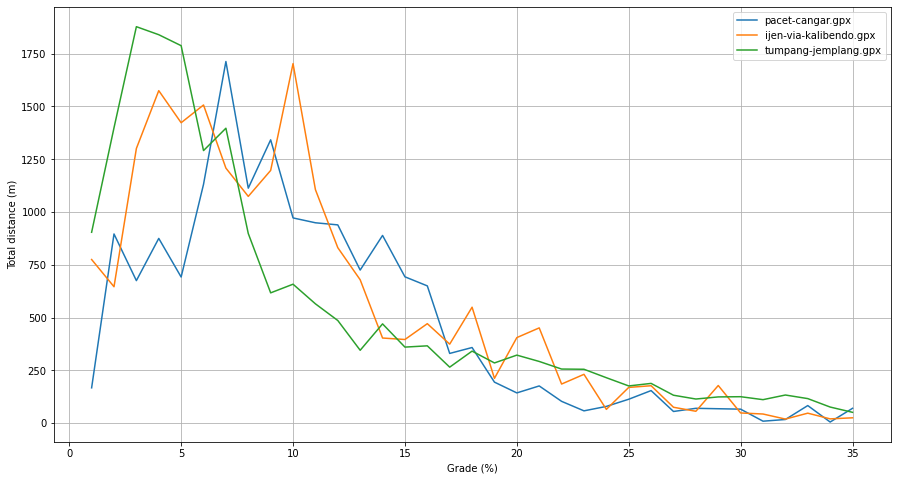

In [11]:
# Interesting climbs in Jatim
dir = 'routes'
filenames = [
    #'kembangbelor-claket.gpx',
    'pacet-cangar.gpx',
    'ijen-via-kalibendo.gpx',
    'tumpang-jemplang.gpx',
]
files = [os.path.join(dir, f) for f in filenames]

plot_gradients(files)

## Power Cadence and Cog at Grade

Calculate the "optimal" cog selection, cadence, and speed for each gradient given the specified average power, max power, minimum speed, minimum cadence, max torque, body weight, bike weight, and tire size parameters.

In [12]:
def power_cadence_cog_at_grade(avg_power, max_power, min_speed, min_cadence, 
                               chainring, cogs, max_torque, max_cadence=MAX_CADENCE,
                               body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                               min_grade=5, max_grade=20, tire_size=(700,30)):
    cogs = sorted(cogs)
    all_grades = np.arange(min_grade,max_grade+1)
    grades = []
    powers = []
    wkgs = []
    speeds = []
    cadences = []
    best_cogs = []
    
    for grade in all_grades:
        best_cog = None
        best_cad = None
        best_power = None
        best_speed = None
        for power in range(avg_power, max_power, 5):
            if power != avg_power:
                power = power // 5 * 5
            for cog in cogs:
                speed = calculate_speed(1000, 1000*grade/100, power, body_weight, bike_weight)
                if speed < min_speed:
                    continue
                cad = cadence_at_speed(speed, chainring, cog, tire_size)
                torque = power / cad
                if cad >= min_cadence and torque < max_torque:
                    #print(f'grade: {grade}, power: {power}, cog: {cog}, cad: {cad}')
                    if cad > max_cadence and best_cog is not None:
                        break
                    best_cog = cog
                    best_cad = cad
                    best_power = power
                    best_speed = speed
                    #break
                    
            if best_cog is not None:
                break
                
        if not best_cog:
            print(f'Unable to cycle at grade {grade}% or above. '
                   'Unable to satisfy min_cadence, min_speed, or max_torque using '
                   'the specified max_power/cogs')
            break
        
        #print(f'{grade}%: {power} W, {speed:.1f} km/h, {cad} RPM, cog: {best_cog}')
        
        grades.append(grade)
        powers.append(best_power)
        wkgs.append(best_power / body_weight)
        speeds.append(best_speed)
        cadences.append(best_cad)
        best_cogs.append(best_cog)
    
    df = pd.DataFrame({'grade (%)': grades, 'power': powers, 'w/kg': wkgs,
                       'speed': speeds, 'cadence': cadences, 'cog': best_cogs})
    df = df.set_index('grade (%)')
    df[['speed', 'w/kg']] = df[['speed', 'w/kg']].round(1)
    df['torque'] = (df['power'] / df['cadence']).round(2)
    return df

In [13]:
# Test
power_cadence_cog_at_grade(AVG_POWER, MAX_POWER, MIN_SPEED, MIN_CADENCE, 
                           CHAINRING, CASSETTES[CASSETTE], MAX_TORQUE,
                           body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                           min_grade=1, max_grade=30,
                           tire_size=TIRE_SIZE)

,power,w/kg,speed,cadence,cog,torque
grade (%),,,,,,
1,157,2.0,23.5,103,17,1.52
2,157,2.0,18.9,103,21,1.52
3,157,2.0,15.3,107,27,1.47
4,157,2.0,12.6,98,30,1.60
5,157,2.0,10.6,94,34,1.67
6,157,2.0,9.1,80,34,1.96
7,157,2.0,8.0,70,34,2.24
8,157,2.0,7.1,62,34,2.53
9,157,2.0,6.4,56,34,2.80


## Climb Plan

### Cassette: 11-34T

## Climb Plan: tumpang-jemplang

Min power       : 120
Chainring       : 30
Unable to cycle at grade 31% or above. Unable to satisfy min_cadence, min_speed, or max_torque using the specified max_power/cogs


#### Power/Speed/Cog/Cadence at Grade

,power,w/kg,speed,cadence,cog,torque,movement,eg,sec,time
grade (%),,,,,,,,,,
0,120,1.5,25.7,100.0,15.0,1.20,1131,3,158.0,0 days 00:02:38
1,120,1.5,20.2,110.0,21.0,1.09,904,16,161.0,0 days 00:02:41
2,120,1.5,15.6,109.0,27.0,1.10,1399,34,323.0,0 days 00:05:23
3,120,1.5,12.3,108.0,34.0,1.11,1878,62,550.0,0 days 00:09:10
4,120,1.5,9.9,87.0,34.0,1.38,1840,83,669.0,0 days 00:11:09
5,120,1.5,8.3,73.0,34.0,1.64,1788,99,776.0,0 days 00:12:56
6,120,1.5,7.1,62.0,34.0,1.94,1291,83,655.0,0 days 00:10:55
7,120,1.5,6.1,54.0,34.0,2.22,1397,101,824.0,0 days 00:13:44
8,120,1.5,5.4,48.0,34.0,2.50,898,77,599.0,0 days 00:09:59


#### Duration spent at each power

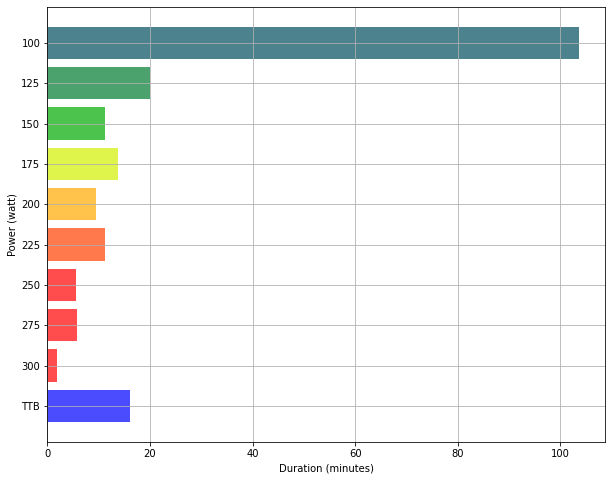

#### Total duration prediction

Avg power: 152
TTB duration: 0 days 00:16:02
Total duration: 0 days 03:18:24


In [14]:
def climb_planner(gpx_filename, min_power, max_power, min_speed, min_cadence, 
                  chainring, cogs, max_torque,
                  body_weight=BODY_WEIGHT, bike_weight=BIKE_WEIGHT,
                  tire_size=TIRE_SIZE):

    display(Markdown(f'## Climb Plan: {os.path.basename(gpx_filename).split(".")[0]}'))

    gpx = summarize_gradients(gpx_filename, min_grad=-5, max_grad=50)
    gpx.index.name = 'grade (%)'

    print(f'Min power       : {min_power}')
    print(f'Chainring       : {chainring}')
    
    POWER_BIN = 25
    min_grade = 0
    
    if isinstance(gpx, str):
        summary = summarize_gradients(gpx, min_grad=0, max_grad=50)
    else:
        summary = gpx
    #display(summary)
    summary = summary.loc[min_grade:,:]
    
    max_grade = summary.index.max()
    pcc = power_cadence_cog_at_grade(min_power, max_power, min_speed, min_cadence, 
                                     chainring, cogs, max_torque,
                                     body_weight=body_weight, bike_weight=bike_weight,
                                     min_grade=min_grade, max_grade=max_grade,
                                     tire_size=tire_size)
    #display(pcc)
    #pcc['torque'] = (pcc['power'] / pcc['cadence']).round(2)

    pcc = pcc.join(summary, how='outer')
    pcc['power'] = pcc['power'].fillna(max_power).astype(int)
    pcc['speed'] = pcc['speed'].fillna(min_speed)
    pcc['sec'] = ((pcc['movement'] / 1000 / pcc['speed']) * 3600).round(0).fillna(0)
    pcc['time'] = pcc['sec'].apply(lambda sec: pd.Timedelta(seconds=sec))

    # Power cog cadence
    display(Markdown('#### Power/Speed/Cog/Cadence at Grade'))
    display(pcc)

    # Power profile (Duration spent at each power)
    display(Markdown('#### Duration spent at each power'))
    pcc_valid = pcc[ pcc['cadence'] > 0 ]
    
    pp = pcc_valid.groupby( pcc_valid['power'] // POWER_BIN * POWER_BIN ).agg('sum')
    
    pcc_ttb = pcc[ pcc['cadence'].isnull() ]
    pp.loc['TTB', 'sec'] = pcc_ttb['sec'].sum()
    
    pp['mins'] = pp['sec'] / 60
    pp['time'] = pp['sec'].apply(lambda sec: pd.Timedelta(seconds=sec))
    pp = pp[['mins', 'time']]
    
    colors = [ZwiftTraining.power_color_gradient(float(pwr)/FTP, output='') if pwr != 'TTB' else 'blue'
              for pwr in pp.index]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    x = np.arange(len(pp))
    ax.barh(x, pp['mins'], color=colors, alpha=0.7)
    ax.grid()
    ax.set_ylabel('Power (watt)')
    #ax.set_yticklabels(pp.index)
    ax.set_yticks(x)
    ax.set_yticklabels([str(val) for val in pp.index])
    ax.set_xlabel('Duration (minutes)')
    ax.invert_yaxis()
    plt.show()

    display(Markdown('#### Total duration prediction'))
    total_duration = pcc['time'].sum()
    total_power_sec = (pcc_valid['power'] * pcc_valid['sec']).sum()
    total_sec = pcc_valid['sec'].sum()
    avg_power = total_power_sec / total_sec
    print(f'Avg power: {int(avg_power)}')
    print(f"TTB duration: {pp.loc['TTB', 'time']}")
    print(f'Total duration: {total_duration}')
    return pcc, pp


torques = []
pps = []

title = CASSETTE
cassette = CASSETTES[title]

display(Markdown(f'### Cassette: {title}'))
pcc, pp = climb_planner('routes/tumpang-jemplang.gpx', 120, MAX_POWER, MIN_SPEED, MIN_CADENCE, CHAINRING, 
                        cassette, MAX_TORQUE)

pcc = pcc[['torque', 'sec']].dropna().rename(columns={'sec': title})
pcc = pcc.set_index('torque')
torques.append(pcc)
pp = pp[['time']].rename(columns={'time': title})
pps.append(pp)

## Comparison of time spent on different power between different cassettes

In [15]:
if False:
    pp = pd.concat(pps, axis=1)
    pp = pp.applymap(lambda t: t.total_seconds() / 60)

    # IGNORE THE MINIMUM POWER
    pp = pp.iloc[1:,:]
    display(Markdown('Raw data:'))
    display(pp)

    W = 25
    pp = pp.groupby(lambda p: (p // W * W) + (W//2)).agg('sum')
    display(Markdown(f'Grouped by {W}w:'))
    display(pp)

    display(Markdown('Chart:'))
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    ax = pp.plot.bar(ax=ax)
    ax.grid()
    ax.set_xlabel('Power (watt)')
    ax.set_ylabel('Duration (minutes)')
    plt.show()

## Torque distribution across different cassettes

In [16]:
def round_prec(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

# Test
round_prec(1.86, 0.25)

1.75

,11-34T
torque,
2.0,24.650000
2.5,9.983333
3.0,16.516667
3.5,15.950000
4.0,5.300000
4.5,12.766667
5.0,9.716667
5.5,9.633333
6.0,4.950000


Chart:

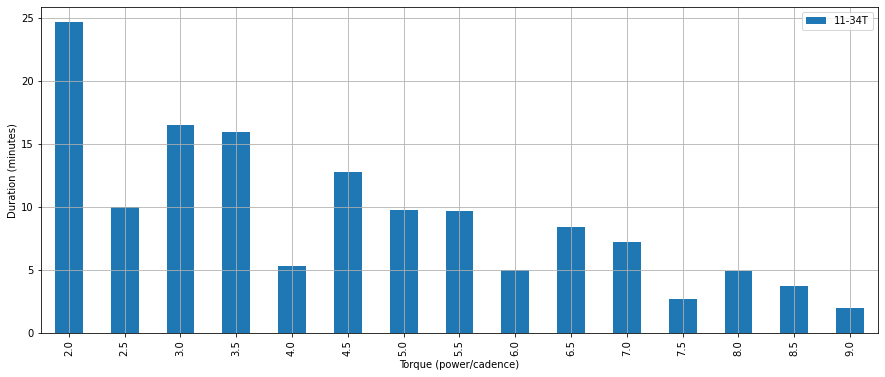

In [17]:
dfs = []
for df in torques:
    df = df.groupby(lambda torque: round_prec(torque, 0.5)).agg('sum')
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df /= 60
df = df.loc[2.0:,:]
display(df)

display(Markdown('Chart:'))
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax = df.plot.bar(ax=ax)
ax.grid()
ax.set_xlabel('Torque (power/cadence)')
ax.set_ylabel('Duration (minutes)')
plt.show()